In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.linear_model import LinearRegression

import joblib

# Load data
df = pd.read_csv('../data/clean_listings.csv')

# Recreate features (same as Day 3)
# Ensure same feature columns exist: Size_SQM, Bedrooms_Num, Bathrooms_Num, Amenity_Count, and location dummies.
# If you saved the feature matrix from Day 3, you can load it; otherwise, recreate.



# Handle missing values 
print("Missing values before imputation:", df[['Size_SQM', 'Bedrooms_Num', 'Bathrooms_Num']].isnull().sum())
median_bathrooms = df['Bathrooms_Num'].median()
df['Bathrooms_Num'] = df['Bathrooms_Num'].fillna(median_bathrooms)


# Top 10 locations dummies
top_locs = df['Location'].value_counts().head(10).index
for loc in top_locs:
    df[f'Loc_{loc}'] = (df['Location'] == loc).astype(int)

feature_cols = ['Size_SQM', 'Bedrooms_Num', 'Bathrooms_Num', 'Amenity_Count'] + [f'Loc_{loc}' for loc in top_locs]
X = df[feature_cols].fillna(0)
y = np.log(df['Price_Millions'])    # log will transform target for better modeling

print("Feature matrix shape:", X.shape)


Missing values before imputation: Size_SQM          0
Bedrooms_Num      0
Bathrooms_Num    13
dtype: int64
Feature matrix shape: (359, 14)


In [39]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# convert test target back once for evaluation use
y_test_real = np.exp(y_test)

In [40]:
# ==========================================================================
# TRAINING RANDOM FOREST - fine-tuning for later
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions (log space)
y_pred_train_rf_log = rf.predict(X_train)
y_pred_test_rf_log = rf.predict(X_test)

# (convert back to real price space)
y_pred_train_rf = np.exp(y_pred_train_rf_log)
y_pred_test_rf = np.exp(y_pred_test_rf_log)
y_train_real = np.exp(y_train)

# Evaluate (REAL price space)
mae_train_rf = mean_absolute_error(y_train_real, y_pred_train_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train_real, y_pred_train_rf))
r2_train_rf = r2_score(y_train_real, y_pred_train_rf)

mae_test_rf = mean_absolute_error(y_test_real, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test_real, y_pred_test_rf))
r2_test_rf = r2_score(y_test_real, y_pred_test_rf)

print("Random Forest Performance:")
print(f"Train MAE: {mae_train_rf:.2f}, RMSE: {rmse_train_rf:.2f}, R²: {r2_train_rf:.3f}")
print(f"Test MAE: {mae_test_rf:.2f}, RMSE: {rmse_test_rf:.2f}, R²: {r2_test_rf:.3f}")

Random Forest Performance:
Train MAE: 8.97, RMSE: 15.78, R²: 0.920
Test MAE: 15.67, RMSE: 26.81, R²: 0.724


In [41]:
# Hyperparameter tuning with GridSearchCV - data is small but will help improve performance
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best parameters:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

# Evaluate tuned model (REAL space)
y_pred_test_rf_tuned_log = best_rf.predict(X_test)
y_pred_test_rf_tuned = np.exp(y_pred_test_rf_tuned_log)

mae_test_rf_tuned = mean_absolute_error(y_test_real, y_pred_test_rf_tuned)
rmse_test_rf_tuned = np.sqrt(mean_squared_error(y_test_real, y_pred_test_rf_tuned))
r2_test_rf_tuned = r2_score(y_test_real, y_pred_test_rf_tuned)

print(f"Tuned RF Test MAE: {mae_test_rf_tuned:.2f}, RMSE: {rmse_test_rf_tuned:.2f}, R²: {r2_test_rf_tuned:.3f}")


Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Tuned RF Test MAE: 15.63, RMSE: 26.77, R²: 0.725


In [42]:
# =============================================================
# TRAINING XGBoost - good for tabular data and often outperforms RF
# fine-tune later with early stopping and more parameters, grid search or random search

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
xgb_model.fit(X_train, y_train)


# Predict on train set
y_pred_train_xgb_log = xgb_model.predict(X_train)
y_pred_train_xgb = np.exp(y_pred_train_xgb_log)

# Predict on test set
y_pred_test_xgb_log = xgb_model.predict(X_test)
y_pred_test_xgb = np.exp(y_pred_test_xgb_log)

# Evaluate XGBoost (REAL price space)
mae_train_xgb = mean_absolute_error(np.exp(y_train), y_pred_train_xgb)
rmse_train_xgb = np.sqrt(mean_squared_error(np.exp(y_train), y_pred_train_xgb))
r2_train_xgb = r2_score(np.exp(y_train), y_pred_train_xgb)

mae_test_xgb = mean_absolute_error(y_test_real, y_pred_test_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_real, y_pred_test_xgb))
r2_test_xgb = r2_score(y_test_real, y_pred_test_xgb)

print("\nXGBoost Performance:")
print(f"Train MAE: {mae_train_xgb:.2f}M, RMSE: {rmse_train_xgb:.2f}M, R²: {r2_train_xgb:.3f}")
print(f"Test MAE: {mae_test_xgb:.2f}M, RMSE: {rmse_test_xgb:.2f}M, R²: {r2_test_xgb:.3f}")


XGBoost Performance:
Train MAE: 2.86M, RMSE: 7.70M, R²: 0.981
Test MAE: 15.21M, RMSE: 26.58M, R²: 0.729


In [43]:
# ===============================================================
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions (log)
y_pred_test_lr_log = lr.predict(X_test)

# >>>  (convert back)
y_pred_test_lr = np.exp(y_pred_test_lr_log)
y_test_real = np.exp(y_test)

# Metrics (REAL space)
mae_test_lr = mean_absolute_error(y_test_real, y_pred_test_lr)
rmse_test_lr = np.sqrt(mean_squared_error(y_test_real, y_pred_test_lr))
r2_test_lr = r2_score(y_test_real, y_pred_test_lr)

print("\nLinear Regression Performance:")
print(f"Test MAE: {mae_test_lr:.2f}, RMSE: {rmse_test_lr:.2f}, R²: {r2_test_lr:.3f}")



Linear Regression Performance:
Test MAE: 23.93, RMSE: 70.64, R²: -0.912


In [44]:
# =======================================================================================================
# COMPARE ALL MODELS - on table - use tuned RF values for fair comparison

comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Tuned Random Forest', 'XGBoost'],
    'Test MAE (Millions KSh)': [mae_test_lr, mae_test_rf, mae_test_rf_tuned, mae_test_xgb],
    'Test RMSE (Millions KSh)': [rmse_test_lr, rmse_test_rf, rmse_test_rf_tuned, rmse_test_xgb],
    'Test R²': [r2_test_lr, r2_test_rf, r2_test_rf_tuned, r2_test_xgb]
})
print(comparison)

                 Model  Test MAE (Millions KSh)  Test RMSE (Millions KSh)  \
0    Linear Regression                23.929609                 70.637130   
1        Random Forest                15.666297                 26.813401   
2  Tuned Random Forest                15.634456                 26.771622   
3              XGBoost                15.211849                 26.582556   

    Test R²  
0 -0.912003  
1  0.724497  
2  0.725355  
3  0.729220  


In [45]:
# ================================================================================

# Random Forest Text Summary
rf_importance_df = pd.Series(best_rf.feature_importances_, index=feature_cols)
rf_importance_df = rf_importance_df.sort_values(ascending=False)

print("\n" + "="*50)
print("RANDOM FOREST FEATURE IMPORTANCE (TEXT SUMMARY)")

print("\nTop 5 Most Important Features:")
print(rf_importance_df.head(5))

print("\nLeast Important Features:")
print(rf_importance_df.tail(3))

# ****************************** 

# XGBoost Text Summary
xgb_importance_df = pd.Series(xgb_model.feature_importances_, index=feature_cols)
xgb_importance_df = xgb_importance_df.sort_values(ascending=False)

print("\n" + "="*50)
print("XGBOOST FEATURE IMPORTANCE (TEXT SUMMARY)")

print("\nTop 5 Most Important Features:")
print(xgb_importance_df.head(5))

print("\nLeast Important Features:")
print(xgb_importance_df.tail(3))

# ***********************************
# Linear Regression Text Summary
lr_coeff_df = pd.Series(lr.coef_, index=feature_cols)
lr_coeff_df = lr_coeff_df.sort_values(ascending=False)

print("\n" + "="*50)
print("LINEAR REGRESSION COEFFICIENT SUMMARY")

print("\nFeatures Increasing Price the Most:")
print(lr_coeff_df.head(5))

print("\nFeatures Decreasing Price the Most:")
print(lr_coeff_df.tail(5))


RANDOM FOREST FEATURE IMPORTANCE (TEXT SUMMARY)

Top 5 Most Important Features:
Size_SQM         0.467628
Bedrooms_Num     0.190873
Bathrooms_Num    0.171339
Loc_Loresho      0.055631
Loc_Lavington    0.022838
dtype: float64

Least Important Features:
Loc_Kiambu Road    0.006685
Loc_Kileleshwa     0.002994
Amenity_Count      0.000000
dtype: float64

XGBOOST FEATURE IMPORTANCE (TEXT SUMMARY)

Top 5 Most Important Features:
Loc_Loresho          0.220858
Bathrooms_Num        0.107596
Loc_Karen            0.092919
Loc_Ongata Rongai    0.091607
Bedrooms_Num         0.077283
dtype: float32

Least Important Features:
Loc_Kiambu Road    0.021073
Loc_Kileleshwa     0.017377
Amenity_Count      0.000000
dtype: float32

LINEAR REGRESSION COEFFICIENT SUMMARY

Features Increasing Price the Most:
Loc_Karen         0.959599
Loc_Runda         0.845000
Loc_Lavington     0.687886
Loc_Loresho       0.291654
Loc_Kileleshwa    0.249775
dtype: float64

Features Decreasing Price the Most:
Amenity_Count      

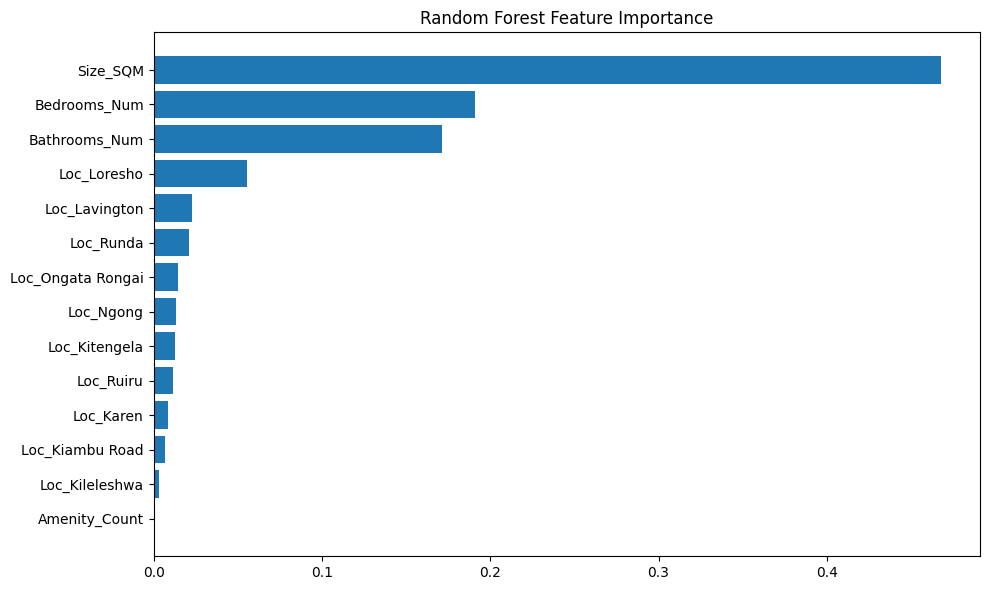

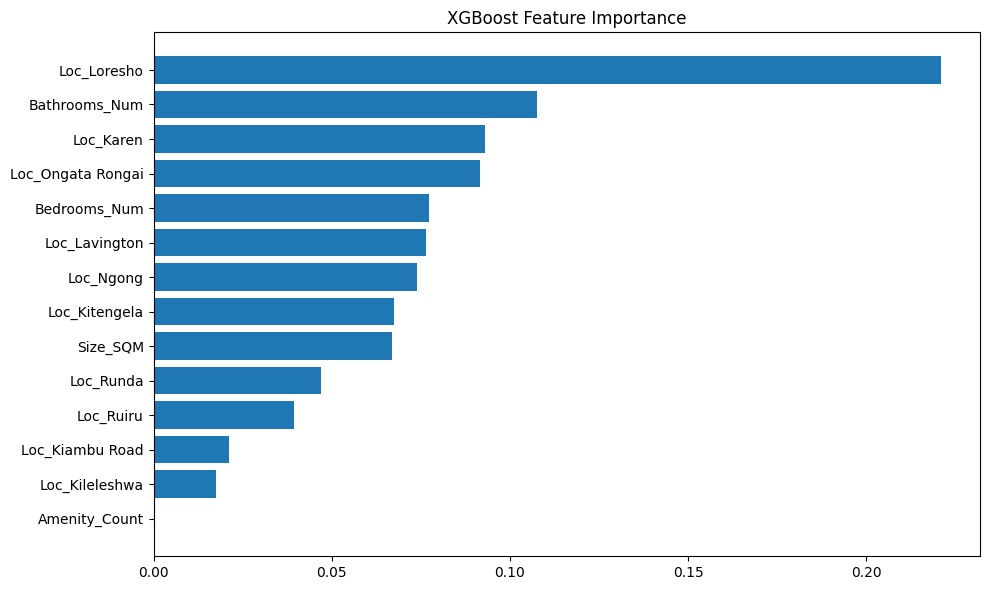

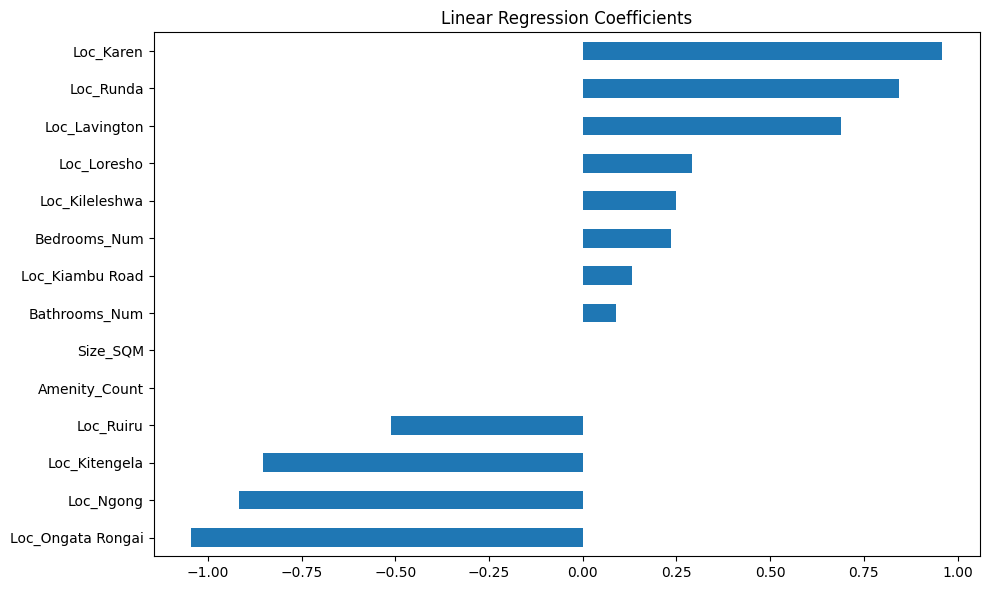

In [46]:
# FEATURE IMPORTANCE PLOTS
# tree-based models like RF and XGBoost provide feature importance scores which can help us understand which features are most influential in predicting house prices.
"""
answer key questions:
    - top features driving predictions
    - are they consistent across models?
    - amenity impact 
    - location impact

"""



# For Random Forest
importances_rf = best_rf.feature_importances_
indices = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10,6))
plt.title("Random Forest Feature Importance")
plt.barh(range(len(indices)), importances_rf[indices], align='center')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/rf_feature_importance.png')
plt.show()

# For XGBoost
importances_xgb = xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(10,6))
plt.title("XGBoost Feature Importance")
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], align='center')
plt.yticks(range(len(indices_xgb)), [feature_cols[i] for i in indices_xgb])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/xgb_feature_importance.png')
plt.show()

# For Linear Regression, use coefficients instead of feature importance
"""Which features increase price
Which decrease price
Strength of impact
"""
coefficients = pd.Series(lr.coef_, index=feature_cols)
coefficients = coefficients.sort_values()

plt.figure(figsize=(10,6))
coefficients.plot(kind='barh')
plt.title("Linear Regression Coefficients")
plt.tight_layout()
plt.show()

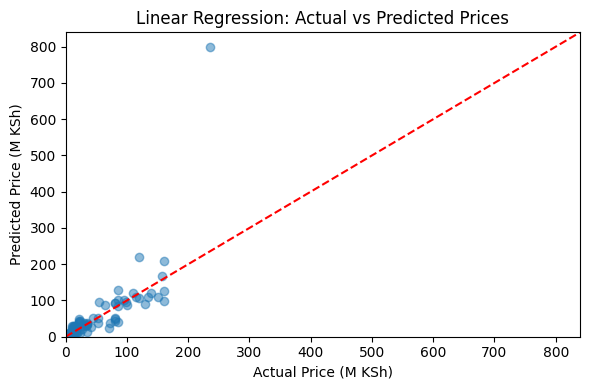

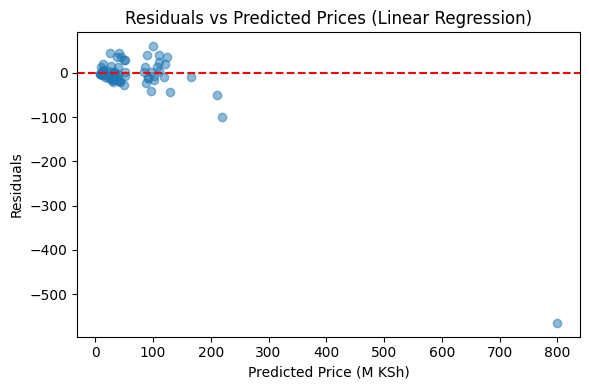


Top 5 largest absolute errors (test set):
     Actual   Predicted    AbsError
180   235.0  799.669592  564.669592
323   120.0  219.869655   99.869655
237   160.0   99.721632   60.278368
157   160.0  210.003047   50.003047
267    70.0   24.943779   45.056221

Original rows for top 5 errors:


,Price_Millions,Location,Size_SQM,Bedrooms_Num,Bathrooms_Num
180,235.0,Karen,929.0000,10,10.0
323,120.0,Karen,630.0000,6,8.0
237,160.0,Lavington,594.5792,5,5.0
157,160.0,Runda,498.0000,7,7.0
267,70.0,Ridgeways,505.0000,3,3.0


In [62]:
# ===============================================================================================
# ACTUAL VS PREDICTED PLOTS - to visually assess how well the model is performing across the range of prices
"""If points lie close to the red line → good model
If scattered widely → weak model
"""

plt.figure(figsize=(6,4))
plt.scatter(y_test_real, y_pred_test_lr, alpha=0.5)
lims = [0, max(y_test_real.max(), y_pred_test_lr.max()) * 1.05]
plt.plot(lims, lims, 'r--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual Price (M KSh)")
plt.ylabel("Predicted Price (M KSh)")
plt.title("Linear Regression: Actual vs Predicted Prices")
plt.tight_layout()
plt.show()


# RESIDUAL PLOTS - to check for patterns in errors which can indicate model issues like heteroscedasticity or non-linearity
"""Whether errors are random (good)
Or patterned (bad → model missing nonlinear relationships)
"""

residuals = y_test_real - y_pred_test_lr

plt.figure(figsize=(6,4))
plt.scatter(y_pred_test_lr, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Price (M KSh)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Prices (Linear Regression)")
plt.tight_layout()
plt.show()


# Top absolute errors
results = pd.DataFrame({'Actual': y_test_real, 'Predicted': y_pred_test_lr})
results['AbsError'] = (results['Predicted'] - results['Actual']).abs()
top5 = results.sort_values('AbsError', ascending=False).head(5)
print('\nTop 5 largest absolute errors (test set):')
print(top5)

# Show original rows for these outliers (if df still available)
if 'df' in globals():
    print('\nOriginal rows for top 5 errors:')
    display(df.loc[top5.index, ['Price_Millions','Location','Size_SQM','Bedrooms_Num','Bathrooms_Num']])
else:
    print('\nOriginal DataFrame `df` not available in this namespace.')


In [49]:
# ==============================================================================
# SAVE BEST MODEL - with LOWEST RMSE for future use

# Select best model based on lowest RMSE instead of highest R² - more intuitive for regression tasks
"""    WHY FOR THIS PROJECT
Random Forest has lower MAE than Linear Regression (17.53 vs 18.01)
But its RMSE is dramatically worse (27.85 vs 21.89)
"""

model_objects = {
    "Linear Regression": (lr, rmse_test_lr),
    "Random Forest": (rf, rmse_test_rf),
    "Tuned Random Forest": (best_rf, rmse_test_rf_tuned),
    "XGBoost": (xgb_model, rmse_test_xgb)
}

best_model_name = min(model_objects, key=lambda x: model_objects[x][1])
best_model_object = model_objects[best_model_name][0]
best_model_rmse = model_objects[best_model_name][1]

print("\n" + "="*50)
print(f"Best Performing Model LOWEST RMSE: {best_model_name}")
print(f"Test RMSE: {best_model_rmse:.2f} Million KSh")
print("="*50)

# Save automatically
model_path = f"../models/{best_model_name.replace(' ', '_').lower()}_model.pkl"
joblib.dump(best_model_object, model_path)

print(f"\nBest model saved automatically at: {model_path}")



Best Performing Model LOWEST RMSE: XGBoost
Test RMSE: 26.58 Million KSh

Best model saved automatically at: ../models/xgboost_model.pkl


In [50]:

# (Save correct MAE of BEST model in real price space)

mae_objects = {
    "Linear Regression": (lr, mae_test_lr),
    "Random Forest": (rf, mae_test_rf),
    "Tuned Random Forest": (best_rf, mae_test_rf_tuned),
    "XGBoost": (xgb_model, mae_test_xgb)
}

best_mae_model_name = min(mae_objects, key=lambda x: mae_objects[x][1])
best_mae_model_object = mae_objects[best_mae_model_name][0]
best_mae_value = mae_objects[best_mae_model_name][1]

print(f"Best MAE Model: {best_mae_model_name} with MAE = {best_mae_value:.2f}M KSh")

# Save the best MAE value for reference
model_path_mae = f"../models/{best_mae_model_name.replace(' ', '_').lower()}_mae.pkl"
joblib.dump(best_mae_value, model_path_mae)
print(f"Best model MAE saved at: {model_path_mae}")

Best MAE Model: XGBoost with MAE = 15.21M KSh
Best model MAE saved at: ../models/xgboost_mae.pkl
